We are going to implement a code for Linear Quadratic Control problem 

Loss function = $\dfrac1M\sum_{t=0}^{N-1}((aX_t^2+bX_t+Au_t^2+Bu_t)\delta_t+\alpha X_T^2+\beta X_T)$

where $\delta_t=\frac{N}{T}$

State Process $X_{t+1}=X_t+(cX_t+du_t)\delta_t+\sigma\delta_t\epsilon_t$

The HJB equation is given by

$0=\partial_t V(t,x)+\frac{\sigma^2}{2}\partial_x^2V(t,x) +cx\partial_xV(t,x)+ax^2+bx+\inf_u\Big[Au^2+\Big(B+d\partial_xV(t,x)\Big)u\Big]$

$V(T,x)=\alpha x^2+\beta x$.

The optimal solution solution obtained as
$u^*=-\frac{B+d\partial_xV(t,x)}{2A}$
depends on the value function $V(t,x)$, which is the solution of the following PDE
$0=\partial_t V(t,x)+\frac{\sigma^2}{2}\partial_x^2V(t,x) +cx\partial_xV(t,x)+ax^2+bx-\frac{\big(B+d\partial_xV(t,x)\big)^2}{4A}$

$V(T,x)=\alpha x^2+\beta x$.

We assume that the value function is quadratic in $x$,

$V(t,x)=f(t)x^2+h(t)x+k(t)$. 

By substituting $V$ in the HJB PDE we get the following system of Riccati ODE.

$0=f'+a+2cf-\frac{d^2}{A}f^2;  f(T)=\alpha$

$0=h'+b-\frac{(B+dh)d}{A}f;  h(T)=\beta$

$0=k'+\sigma^2 f-\frac{1}{4A}(B+dh)^2;  k(T)=0$

By solving this system of first order ODE we can get $f,h,t$ in closed form and we obtain the optimal solution as

$u^*=-\frac{B+d(2xf(t)+h(t))}{2A}$

In [22]:
import numpy as np
import time
from scipy import misc
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import pandas as pd
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

In [23]:
M=1000
ite=10
T=1
delta = torch.tensor(T/ite)
a=1
b=1
c=1
d=1
A=1
B=1
sigma=0.01
alpa=1
beta=1
neuron_model_psi=16
dim_n=2
print(delta)

tensor(0.1000)


In [24]:
model= torch.nn.Sequential(
    torch.nn.Linear(dim_n, neuron_model_psi),
    torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
#     torch.nn.Linear(neuron_model_psi, neuron_model_psi),
#     torch.nn.ReLU(),
    torch.nn.Linear(neuron_model_psi,1)
)

In [25]:
# model= torch.load('model_N10_LQC.pth')


In [26]:
t=torch.zeros([M,1])
up_lim=100
#z=np.zeros([M,ite+1])+np.random.rand(M,1)
z=torch.randn(size=(M, ite+1))
x_train=torch.FloatTensor(M,1).uniform_(0,up_lim)   #remaining balance R_t   #To get a positive solution R_t has to be greater than D_t
data=torch.cat((t,x_train),dim=1)
# print(data.dtype)
# print(z.dtype)
# print(z[:,2].shape)
#print(x)

In [27]:
def update(x3,psi,z,i):
    t=(x3[:,0]+(T/ite))
    #print(x3[:,1].shape,z[:,i].shape,psi.shape)
    x=x3[:,1]+(c*x3[:,1]+d*psi)*delta+sigma*torch.sqrt(delta)*z[:,i]
    up=torch.cat((t.unsqueeze(1),x.unsqueeze(1)),dim=1)
#     print('up shape=', up.shape)
    return up

def loss_func(x2,psi):
    loss=a*torch.pow(x2[:,1],2)+b*x2[:,1]+A*torch.pow(psi,2)+B*psi
    return loss

def loss_func_ter(x4):
    loss=alpa*torch.pow(x4[:,1],2)+beta*x4[:,1]
    return loss

def unit(x1,model,i):
    psi=model(x1).squeeze(1)
    los=loss_func(x1,psi)
    upd=update(x1,psi,z,i)
    #print('unit print=',psi.shape,los.shape,upd.shape)
    return psi,los,upd

def loss_func_total(u,model,epoch):
    loss=torch.zeros(M,ite)
    psi=torch.zeros(M,ite)
    state_var=[]
    if (epoch==max_epochs-1):
        state_var.append(u.detach().numpy())   
    for i in range(ite+1):
        if(i<ite):
            psi_run,loss_run,u_run=unit(u,model,i)
            #print('los func=',psi_run.shape,loss_run.shape)
            loss[:,i]=loss_run
            #print(loss)
            psi[:,i]=psi_run
            #print(psi)
            u=u_run
            if (epoch==max_epochs-1):
                state_var.append(u.detach().numpy())             
            #print(u)
        else:
            loss_ter=loss_func_ter(u)
          #print('ter',loss_ter.shape)
        #print(torch.sum(loss,dim=1))
    loss=torch.sum(loss,dim=1)*delta+loss_ter
    #print(loss.shape)
    return torch.mean(loss),state_var


In [29]:
start=time.time()
lr1 = 8e-3
max_epochs = 5000
cost_ar=[]
optimizer = optim.Adam(model.parameters(), lr1)

#print(psi.shape)
for epoch in range(max_epochs):
  t0 = time.time()
  optimizer.zero_grad()
  cost,state_var_train=loss_func_total(data,model,epoch)
  cost.backward()
  optimizer.step()
  cost_ar.append(cost)
  #print(loss.item())
  # if (epoch % 100==0):
  #   print("At epoch {} the mean cost is {}.".format(epoch,cost.detach()))
  if (epoch % int(max_epochs/5)== int(max_epochs/5)-1) | (epoch == 0):
      print("At epoch {:,} the loss is {:.10E}.  Epoch training time = {:.2E} ms".format(epoch+1,cost.detach(),1000*(time.time()-t0)))
end=time.time()
total_time=end-start
print('Training time=',total_time)


At epoch 1 the loss is 8.0776816406E+03.  Epoch training time = 1.87E+02 ms
At epoch 1,000 the loss is 8.0769213867E+03.  Epoch training time = 2.28E+01 ms


KeyboardInterrupt: 

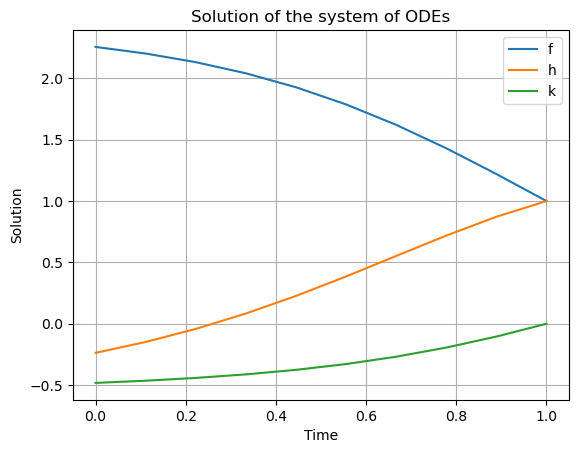

In [30]:
# Define the system of ODEs
def system_of_odes(t, y):
    dydt = [
        a+2*c*y[0]-(np.power(d,2)*np.power(y[0],2))/A,                 # df/dt = a+2cf-d^2*f^2/A; f(0)=alpa
        b-(B+d*y[1])*d*y[0]/A,                       # dh/dt = b-(B+dh)fd/A; h(0)=beta
        np.power(sigma,2)*y[0]-(B+d*y[1])**2/(4*A)        # dk/dt = sigma^2*f-(B+dh)^2/4A; k(0)=0
    ]
    return dydt

# Initial conditions
initial_conditions = [alpa, beta, 0]  # Initial values for y1, y2, and y3

# Time span
t_span = (0, T)  # Start and end time

# Solve the system of ODEs
sol = solve_ivp(system_of_odes,t_span, initial_conditions, t_eval=np.linspace(0, T, ite))

f=np.flip(sol.y[0])
h=np.flip(sol.y[1])
k=np.flip(sol.y[2])
# Plot the solution
plt.plot(sol.t, f, label='f')
plt.plot(sol.t, h, label='h')
plt.plot(sol.t, k, label='k')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Solution of the system of ODEs')

plt.legend()
plt.grid(True)
# plt.show()


In [31]:
def optimal_soln(x,f,h):
    u=-(B+d*(2*x*f+h))/(2*A)
    return u

def value_func(x,f,h,k):
    V=f*np.power(x,2)+h*x+k
    return V

def total_cost(x,u):
    cost_run=0.0
    for i in range(ite+1):
        if(i<ite):
            cost_run=cost_run+a*np.power(x[i],2)+b*x[i]+A*np.power(u[i],2)+B*u[i]
        else:
            cost_ter=alpa*np.power(x[i],2)+beta*x[i]
    return cost_run*delta.numpy()+cost_ter    

# Neural Network Prediction

In [32]:
M1=2
x_ar=[]
z1=torch.randn(size=(M1,ite))
t_test=torch.zeros([M1,1])
x1=torch.linspace(0.3*up_lim,0.5*up_lim, steps=M1).unsqueeze(1)
x_test=torch.cat((t_test,x1),dim=1)
pred_soln=torch.zeros(M1,ite)
for i in range(ite):
    x_ar.append(x_test[:,1].numpy())
    soln_pred=model(x_test).squeeze(1).detach()
    pred_soln[:,i]=soln_pred
    x_test=update(x_test,soln_pred,z1,i)
x_ar.append(x_test[:,1].numpy())
state_var=np.squeeze(np.array(x_ar))
state_var=state_var.transpose()
print(state_var.shape)

(2, 11)


In [33]:
t_eval=np.linspace(0,T,ite)
u=optimal_soln(state_var[:, :-1],f,h)
V=value_func(state_var[:, :-1],f,h,k)
pred=pred_soln.numpy()
for i in range(M1):
    print('state variable',state_var[i])
    print('\n True solution',u[i])
    true_cost=total_cost(state_var[i],u[i])
    print('\n True cost=',true_cost)
    print('\n Predicted solution',pred[i])
    pred_cost=total_cost(state_var[i],pred[i])
    print('\n Predicted cost=',pred_cost)
    print('Percent Error in cost=',np.abs(100*(np.abs(true_cost)-np.abs(pred_cost))/true_cost),'%\n')

state variable [30.       26.75936  23.946045 21.529255 19.615086 18.155046 17.02999
 16.050396 15.268498 14.800774 14.726119]

 True solution [-68.07517014 -59.36677319 -51.53699751 -44.49615622 -38.4251082
 -33.15055075 -28.38651741 -23.8169693  -19.56990223 -15.80077362]

 True cost= 2387.929349591038

 Predicted solution [-62.433243 -54.85929  -48.124725 -40.70605  -34.24381  -29.355745
 -26.77546  -23.849993 -19.933975 -15.523996]

 Predicted cost= 2136.9290452789637
Percent Error in cost= 10.51121149606294 %

state variable [50.       44.685192 40.110752 36.23687  32.99313  30.321098 28.236637
 26.776033 25.743624 25.169243 25.090834]

 True solution [-113.20432153  -98.85076427  -86.00347932  -74.52344182  -64.2137553
  -54.90115906  -46.55553592  -39.15835136  -32.35385785  -26.16924286]

 True cost= 6659.487428303051

 Predicted solution [-103.14998   -90.40846   -78.88407   -68.69273   -59.700485  -51.143925
  -42.886215  -37.0762    -31.531189  -25.970646]

 Predicted cost= 

In [34]:
state_var.shape

(2, 11)

# Optimal Solution at different time steps

In [35]:
state_var

array([[30.      , 26.75936 , 23.946045, 21.529255, 19.615086, 18.155046,
        17.02999 , 16.050396, 15.268498, 14.800774, 14.726119],
       [50.      , 44.685192, 40.110752, 36.23687 , 32.99313 , 30.321098,
        28.236637, 26.776033, 25.743624, 25.169243, 25.090834]],
      dtype=float32)

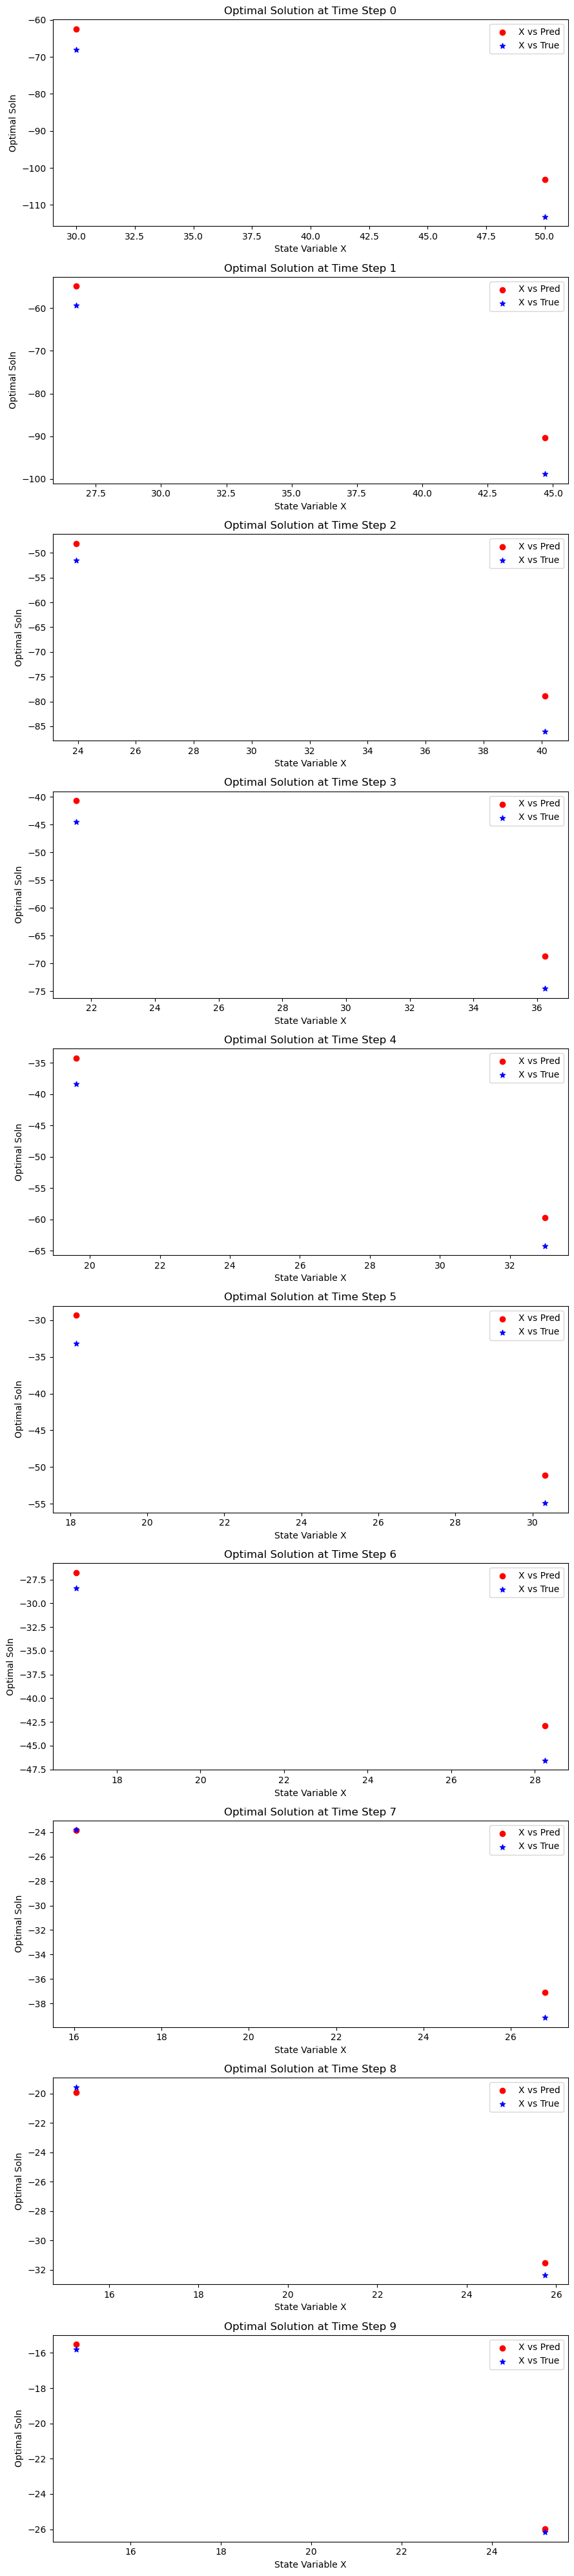

In [36]:
import matplotlib.pyplot as plt
# Create subplots
ite=10
fig, axs = plt.subplots(ite, 1, figsize=(9, 40))
state_var_=state_var[:, :-1]
for i, ax in enumerate(axs):
    ax.scatter(state_var_[:,i],pred[:,i],color='r',label='X vs Pred', marker='o')
    ax.scatter(state_var_[:,i],u[:,i], color='blue', label='X vs True', marker='*')
    ax.set_xlabel('State Variable X')
    ax.set_ylabel('Optimal Soln')
    ax.set_title(f'Optimal Solution at Time Step {i}')
    ax.legend()
# Adjust layout
plt.tight_layout()


# Optimal solution for different sample path

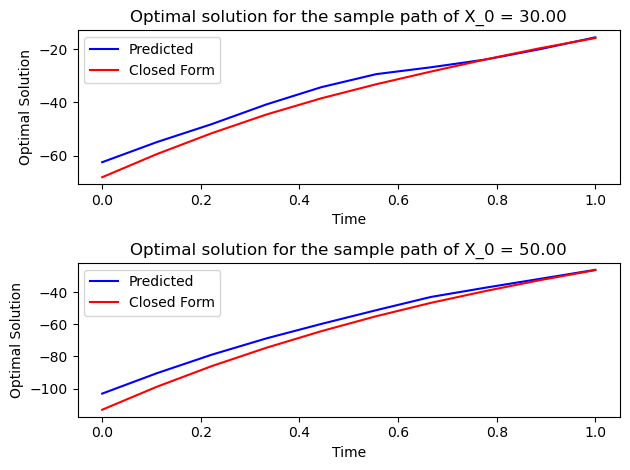

In [37]:
# matplotlib.use('Qt5Agg')
#fig, axs = plt.subplots(M1,1, figsize=(6, 25))
fig, axs = plt.subplots(M1,1)

# Plot x vs y and x vs z on each subplot
for i, ax in enumerate(axs):
    ax.plot(t_eval,pred[i], color='b', label='Predicted')
    ax.plot(t_eval,u[i], color='r', label='Closed Form')
    ax.set_xlabel('Time')
    ax.set_ylabel('Optimal Solution')
    ax.set_title(f'Optimal solution for the sample path of X_0 = {state_var[i,0]:.2f}')
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show plot
# plt.show()

In [38]:
#torch.save(model, 'model_N10_LQC.pth')


# Surface plot for the optimal solution (closed form)

Text(0.5, 0.92, '3D Surface Plot for Optimal solution')

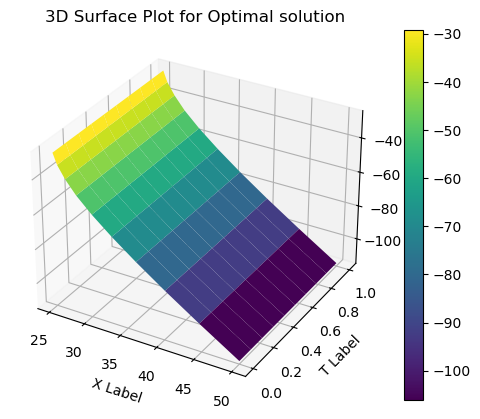

In [39]:

from mpl_toolkits.mplot3d import Axes3D


x_grid, y_grid = np.meshgrid(state_var_[1], t_eval)     # create a grid of x and y values
z= optimal_soln(x_grid,f,h)  # z values, here we just take sin(r), r = sqrt(x^2 + y^2)

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x_grid, y_grid, z, cmap='viridis')  # 'viridis' is just a colormap, you can change it

# Add a color bar which maps values to colors
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('T Label')
ax.set_zlabel('U Label')
ax.set_title('3D Surface Plot for Optimal solution')

# Show plot
# plt.show()


# Surface plot for the Value function

Text(0.5, 0.92, '3D Surface Plot for Value function')

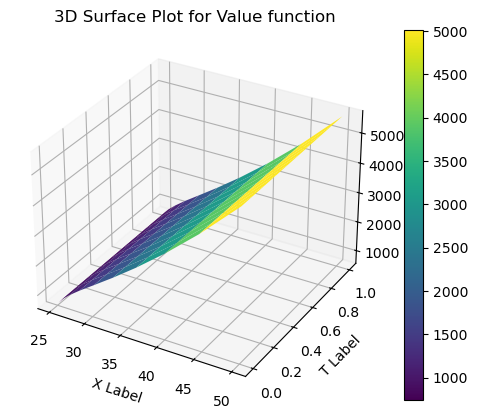

In [40]:

V= value_func(x_grid,f,h,k)  # z values, here we just take sin(r), r = sqrt(x^2 + y^2)

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x_grid, y_grid, V, cmap='viridis')  # 'viridis' is just a colormap, you can change it

# Add a color bar which maps values to colors
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('T Label')
ax.set_zlabel('U Label')
ax.set_title('3D Surface Plot for Value function')

# Show plot
# plt.show()

In [41]:
# state_var_train=np.squeeze(np.array(state_var_train))

# state_var_dic = {'state variable':state_var_train}

# np.savez('state_var_dic_N10_new.npz',**state_var_dic)

In [42]:
# data = np.load('state_var_dic_N10.npz')

# # Accessing the arrays
# array1 = data['state variable']
# data.close()
# print(array1)

In [43]:
# import json
# cost_numpy_list = [tensor.detach().item() for tensor in cost_ar]
# #state_var_train_list=[tensor.detach().tolist() for tensor in state_var_train]

# my_dic = {'Num_sample':M,'Time_step':ite,'T':T,'a':a,'b':b,'c':c,'d':d,'A':A,'B':B,
#           'alpa':alpa,'beta':beta,'Num_Neoron':neuron_model_psi,'Training_time':total_time,'epoch':max_epoch,
#            'accuracy':10,'Training loss':cost_numpy_list}

# file_path=  'N10_lqc_dic.json'
# with open(file_path,'w') as file:
#     json.dump(my_dic,file)
